<a href="https://colab.research.google.com/github/Ratnasari124/Mechine_Learning_Ratnasari/blob/main/Ratnasari_2241720007_Mesin_Learning__JS_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Job Sheet 10**

Recurrent Neural Network (RNN)


---

Anggota Kelompok :      
- Lalu Immaratul Ardhi Ganeru 	(2241720169)
- M. Kemal Nugraha 			(2241720044)
- M. Ariel Saputra 			(2241720034)
- Ratnasari 				(2241720007)
---
Link Jobsheet : https://polinema.gitbook.io/jti-modul-praktikum-pembelajaran-mesin/job-sheet-10-recurrent-neural-network-rnn


# **PRAKTIKUM 1**

---

RNN untuk Analisis Sentimen

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

`tfds.disable_progress_bar()` digunakan untuk menonaktifkan tampilan progress bar saat mendownload atau memproses data di TensorFlow Datasets.

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Kode tersebut digunakan untuk menampilkan grafik metrik pelatihan dan validasi (seperti akurasi atau loss) dari model Keras seiring bertambahnya epoch, sehingga memudahkan pemantauan performa model selama proses pelatihan.


---

detail penjelasan kode
- plt.plot(history.history[metric]): Menggambar grafik dari metrik pelatihan untuk setiap epoch.
- plt.plot(history.history['val_'+metric], ''): Menggambar grafik dari metrik validasi untuk setiap epoch. Metrik validasi menggunakan prefix 'val_' sebelum nama metrik.
- plt.xlabel("Epochs"): Memberi label pada sumbu-x sebagai "Epochs" (jumlah epoch pelatihan).
- plt.ylabel(metric): Memberi label pada sumbu-y sesuai dengan metrik yang diberikan.
- plt.legend([metric, 'val_'+metric]): Menambahkan legenda yang menunjukkan grafik pelatihan dan validasi.

## Setup input pipeline

---



Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manua

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Kode ini memuat dataset ulasan IMDB, membaginya menjadi data pelatihan dan pengujian, lalu memeriksa struktur elemen dalam dataset untuk memahami bentuk data yang akan diproses dalam model pembelajaran mesin.

---

detail :
- 'imdb_reviews': Nama dataset yang dimuat, yaitu ulasan film dari IMDB.
- with_info=True: Meminta informasi tambahan tentang dataset, yang akan disimpan dalam variabel info.
- as_supervised=True: Mengatur dataset agar diformat sebagai pasangan (input, label), sehingga setiap elemen dataset berisi teks ulasan (input) dan label (positif/negatif).
- Variabel train_dataset menyimpan data pelatihan, dan test_dataset menyimpan data pengujian.
- train_dataset.element_spec digunakan untuk memeriksa struktur atau spesifikasi elemen dalam dataset.


Awalnya ini mengembalikan dataset (teks, pasangan label):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


untuk menampilkan contoh satu data (ulasan) beserta labelnya dari dataset pelatihan (train_dataset).

---


detail :    
- train_dataset.take(1) mengambil satu batch data dari train_dataset.
- for example, label in ... digunakan untuk mengiterasi contoh data (ulasan) dan labelnya. Meskipun hanya mengambil satu contoh, ini tetap harus dalam bentuk loop.
- example.numpy(): Mengonversi tensor example (teks ulasan) menjadi format numpy, sehingga bisa ditampilkan sebagai teks biasa.
- label.numpy(): Mengonversi tensor label menjadi format numpy, sehingga labelnya dapat ditampilkan sebagai angka (0 atau 1), di mana 0 biasanya berarti ulasan negatif, dan 1 berarti ulasan positif.

Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

def cast_to_object(text, label):
  return tf.cast(text, tf.string), tf.cast(label, tf.int64)  # Or any desired dtype

train_dataset = train_dataset.map(cast_to_object)
test_dataset = test_dataset.map(cast_to_object)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'This film does a superb job of depicting the plight of an ALS (Lou Gehrig\'s Disease)sufferer. The subject is done with compassion as well as humor. Helena Bonham Carter is so convincing as a person with ALS that I found it hard to believe that she was only acting. Kenneth Branagh, a superb actor, lives up to expectations as the quirky artist who misbehaves and is forced to provide companionship to Helena\'s character as part of his "community service", an alternative to prison time. Watching the development of the relationship between these two is a treat from beginning to end. Tha fact that it is a fairy tale does not detract from the fabulous performances. One comes to care deeply for the two of them.'
 b'(spoilers)The one truly memorable part of this otherwise rather dull and tepid bit of British cuisine is Steiner\'s henna rinse, one of the worst dye jobs ever. That, and the magnificent caterpillar eyebrows on the old evil dude who was trying to steal Steiner\'s inventi

Kode ini menyiapkan dataset untuk pelatihan dengan mengacak, membagi menjadi batch, mengonversi tipe data, dan menampilkan contoh data beserta labelnya.


---
detail :    
- BUFFER_SIZE: Ukuran buffer untuk mengacak dataset, yang membantu meningkatkan keragaman data saat pelatihan.
- BATCH_SIZE: Jumlah contoh data yang akan diproses sekaligus dalam satu iterasi.
- shuffle(BUFFER_SIZE): Mengacak urutan data dalam train_dataset.
- batch(BATCH_SIZE): Membagi dataset menjadi batch yang berisi 64 contoh.
- prefetch(tf.data.AUTOTUNE): Mengoptimalkan pengambilan data dengan memuat data berikutnya saat model sedang dilatih, yang meningkatkan efisiensi.
- cast_to_object: Fungsi yang mengonversi tipe data teks menjadi string dan label menjadi integer 64-bit.


## Buat Teks Encoder

---



In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

tujuan kode ini untuk mengonversi ulasan teks menjadi representasi numerik, dengan membatasi kosakata pada 1000 kata paling umum yang terdapat dalam dataset pelatihan.

---
detail :    
- tf.keras.layers.TextVectorization: Layer Keras yang digunakan untuk mengonversi teks menjadi token numerik. Parameter max_tokens mengatur batas jumlah kata unik.
- encoder.adapt(...): Mengadaptasi encoder dengan data dari train_dataset, dalam hal ini hanya mengambil teks (text).
- map(lambda text, label: text): Menggunakan fungsi map untuk mengekstrak hanya teks dari pasangan (text, label).

In [8]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Kode ini berfungsi untuk mengambil kosakata yang dihasilkan oleh layer TextVectorization dan menampilkan 20 kata pertama dari kosakata tersebut, memberikan gambaran tentang kata-kata yang akan digunakan dalam proses pelatihan model.

In [9]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 11,  20, 121, ...,   0,   0,   0],
       [  1,  29, 353, ...,   0,   0,   0],
       [  1,   2, 119, ...,   0,   0,   0]])

mengonversi teks ulasan menjadi representasi numerik menggunakan encoder yang telah diadaptasi, lalu mengambil dan menyimpan tiga indeks pertama dari representasi tersebut dalam bentuk array NumPy.

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This film does a superb job of depicting the plight of an ALS (Lou Gehrig\'s Disease)sufferer. The subject is done with compassion as well as humor. Helena Bonham Carter is so convincing as a person with ALS that I found it hard to believe that she was only acting. Kenneth Branagh, a superb actor, lives up to expectations as the quirky artist who misbehaves and is forced to provide companionship to Helena\'s character as part of his "community service", an alternative to prison time. Watching the development of the relationship between these two is a treat from beginning to end. Tha fact that it is a fairy tale does not detract from the fabulous performances. One comes to care deeply for the two of them.'
Round-trip:  this film does a superb job of [UNK] the [UNK] of an [UNK] [UNK] [UNK] [UNK] the subject is done with [UNK] as well as humor [UNK] [UNK] [UNK] is so [UNK] as a person with [UNK] that i found it hard to believe that she was only acting [UNK] [UNK] a superb act

digunakan untuk menampilkan dan membandingkan teks ulasan asli dengan teks yang telah dikonversi menjadi representasi numerik dan kemudian dikembalikan (reverse-encoded) kembali ke bentuk teks.

## Buat Model


---



In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Kode ini membangun model Keras dengan beberapa layer, termasuk encoding teks, embedding, LSTM bidirectional, dan layer dense, untuk melakukan analisis sentimen atau tugas klasifikasi lain pada ulasan teks. Model ini dirancang untuk mengolah input teks dan menghasilkan output biner.

---
detail :    
- tf.keras.Sequential: Digunakan untuk membuat model dengan tumpukan lapisan (layers) yang saling terhubung secara berurutan.
- encoder:  untuk mengonversi teks menjadi numerik.
- tf.keras.layers.Embedding: Mengubah representasi numerik dari kata menjadi vektor berdimensi rendah
- tf.keras.layers.Bidirectional: Membuat LSTM dapat beroperasi dalam dua arah (maju dan mundur) untuk menangkap konteks dari dua arah dalam urutan.
- tf.keras.layers.LSTM(64): Menggunakan Long Short-Term Memory (LSTM) dengan 64 unit, yang efektif dalam menangkap dependensi jangka panjang dalam data sekuensial seperti teks.


In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Kode ini menghasilkan daftar boolean yang menunjukkan apakah setiap layer dalam model mendukung fitur masking.

layer.supports_masking: Untuk setiap layer, atribut ini mengembalikan nilai boolean (True atau False) yang menunjukkan apakah layer tersebut mendukung masking.

In [18]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(text):
    return tf.data.Dataset.from_tensor_slices([text]).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
dataset = create_dataset(sample_text)

# Prediksi menggunakan model
predictions = model.predict(dataset)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[-0.00645058]


In [19]:
import numpy as np
import tensorflow as tf

# Fungsi untuk memproses teks menjadi dataset
def create_dataset(texts):
    return tf.data.Dataset.from_tensor_slices(texts).batch(1)

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
padding = "the " * 2000  # Padding text
texts = [sample_text, padding]  # List of texts including padding

# Membuat dataset dari teks
dataset = create_dataset(texts)

# Prediksi menggunakan model
predictions = model.predict(dataset)
for pred in predictions:
    print(pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[-0.00645058]
[-0.01259859]


penjelasan untuk 2 kode diatas

Kode ini memproses beberapa teks (termasuk padding) menjadi format dataset yang bisa digunakan oleh model, lalu membuat prediksi untuk setiap teks dan mencetak hasilnya.

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - accuracy: 0.5055 - loss: 0.6894 - val_accuracy: 0.5078 - val_loss: 0.6276
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.6806 - loss: 0.5507 - val_accuracy: 0.8089 - val_loss: 0.4241
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8200 - loss: 0.4075 - val_accuracy: 0.8354 - val_loss: 0.3680
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.8391 - loss: 0.3696 - val_accuracy: 0.8302 - val_loss: 0.3670
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.8493 - loss: 0.3457 - val_accuracy: 0.8542 - val_loss: 0.3369
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8634 - loss: 0.3251 - val_accuracy: 0.8344 - val_loss: 0.3516
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8613 - loss: 0.3253 - val_accuracy: 0.8646 - val_loss: 0.3283
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8675 - loss: 0.3143 - 

menyusun model dengan fungsi loss dan optimizer yang sesuai, kemudian melatih model selama 10 epoch dengan melacak akurasi dan melakukan validasi menggunakan dataset pengujian.

---

detail :      
- model.compile(...): Menyiapkan model untuk pelatihan dengan menentukan fungsi loss, optimizer, dan metrik yang akan dipantau.
- loss=tf.keras.losses.BinaryCrossentropy(from_logits=True): Menentukan fungsi loss sebagai Binary Crossentropy, yang umum digunakan untuk klasifikasi biner. Parameter from_logits=True menunjukkan bahwa output model adalah logits (nilai tidak dinormalisasi).
- optimizer=tf.keras.optimizers.Adam(1e-4): Menggunakan optimizer Adam dengan laju pembelajaran 0.0001, yang membantu model belajar lebih cepat dan lebih efektif.
- metrics=['accuracy']: Mengatur metrik yang akan dilacak selama pelatihan, dalam hal ini adalah akurasi.

## Train Model

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 65ms/step - accuracy: 0.8708 - loss: 0.3059 - val_accuracy: 0.8370 - val_loss: 0.3476
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8691 - loss: 0.3080 - val_accuracy: 0.8651 - val_loss: 0.3103
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.8725 - loss: 0.3015 - val_accuracy: 0.8734 - val_loss: 0.3148
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8728 - loss: 0.3011 - val_accuracy: 0.8526 - val_loss: 0.3341
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8662 - loss: 0.3085 - val_accuracy: 0.8630 - val_loss: 0.3229
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8768 - loss: 0.2933 - val_accuracy: 0.8531 - val_loss: 0.3336
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.8797 - loss: 0.2897 - val_accuracy: 0.8651 - val_loss: 0.3178
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.8782 - loss: 0.2917 - 

tujuannya untuk :   
- Melatih model menggunakan dataset pelatihan (train_dataset) selama 10 epoch.
- Mengevaluasi performa model secara berkala menggunakan dataset pengujian (test_dataset) untuk memonitor akurasi dan loss selama pelatihan.
- Menyimpan hasil pelatihan (seperti akurasi dan loss) dalam variabel history untuk analisis lebih lanjut.

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8620 - loss: 0.3217
Test Loss: 0.32216793298721313
Test Accuracy: 0.860319972038269


untuk mengevaluasi performa model setelah dilatih, menggunakan dataset pengujian.


model.evaluate(test_dataset): Fungsi ini menghitung nilai loss dan metrik (dalam hal ini, akurasi) untuk model berdasarkan dataset pengujian (test_dataset).


print('Test Loss:', test_loss): Mencetak nilai loss untuk dataset pengujian.

print('Test Accuracy:', test_acc): Mencetak nilai akurasi untuk dataset pengujian.

(0.0, 0.3504389077425003)

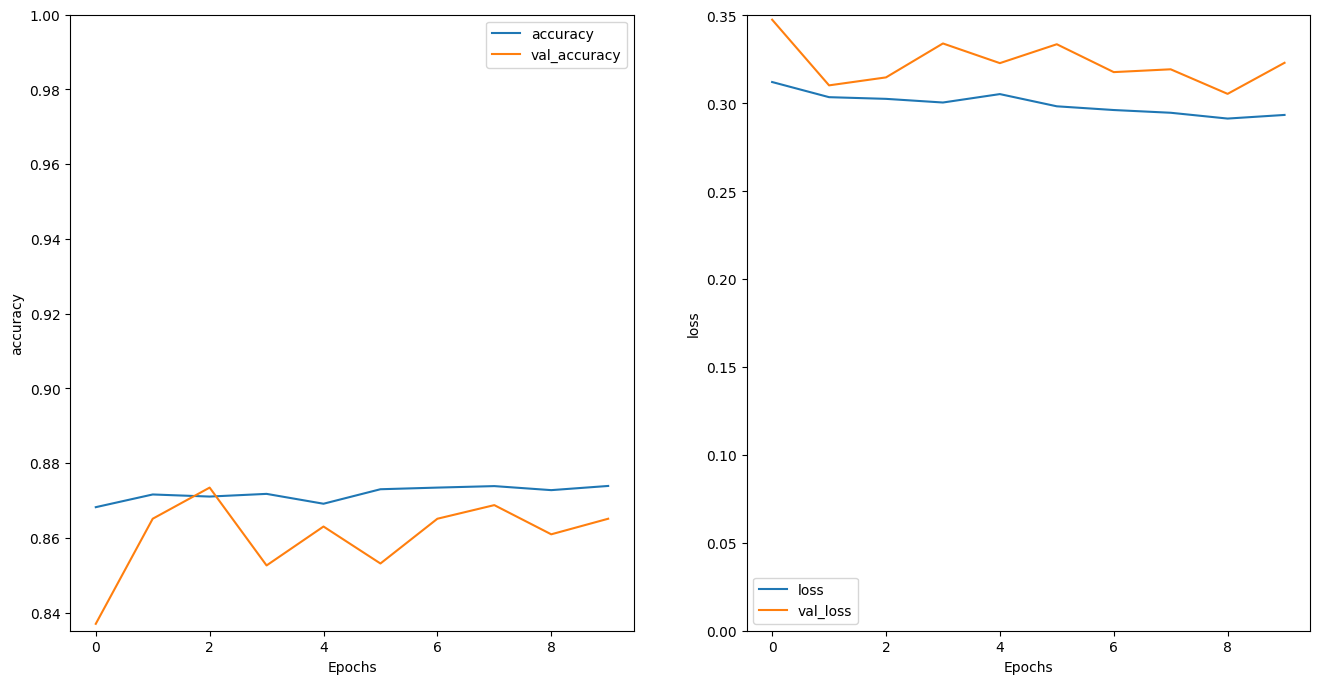

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

untuk memvisualisasikan performa model selama pelatihan dengan menampilkan dua grafik dalam satu figur

In [26]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
[0.24091214]


Mengambil contoh teks ulasan film, mengonversinya menjadi tensor, dan kemudian menggunakan model pembelajaran mendalam untuk membuat dan mencetak prediksi berdasarkan teks tersebut.

- tf.convert_to_tensor([sample_text]): Mengonversi sample_text menjadi tensor TensorFlow.
- model.predict(sample_tensor): Menggunakan model yang telah dilatih untuk membuat prediksi berdasarkan sample_tensor.
- print(predictions[0]): Mencetak hasil prediksi pertama dari output mode

## Stack two or more LSTM layers

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 119ms/step - accuracy: 0.5209 - loss: 0.6808 - val_accuracy: 0.8026 - val_loss: 0.4572
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8241 - loss: 0.3943 - val_accuracy: 0.8172 - val_loss: 0.3585
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 109ms/step - accuracy: 0.8487 - loss: 0.3505 - val_accuracy: 0.8672 - val_loss: 0.3121
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step - accuracy: 0.8570 - loss: 0.3302 - val_accuracy: 0.8490 - val_loss: 0.3325
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8561 - loss: 0.3291 - val_accuracy: 0.8557 - val_loss: 0.3139
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.8659 - loss: 0.3106 - val_accuracy: 0.8510 - val_loss: 0.3224
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8679 - loss: 0.3055 - val_accuracy: 0.8344 - val_loss: 0.3288
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - accuracy: 0.8629 - loss: 0

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8400 - loss: 0.3276
Test Loss: 0.32740071415901184
Test Accuracy: 0.8392400145530701


In [32]:
import numpy as np
import tensorflow as tf

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')

# Mengonversi teks menjadi tensor
sample_tensor = tf.convert_to_tensor([sample_text])

# Prediksi menggunakan model
predictions = model.predict(sample_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[-2.2565567]]


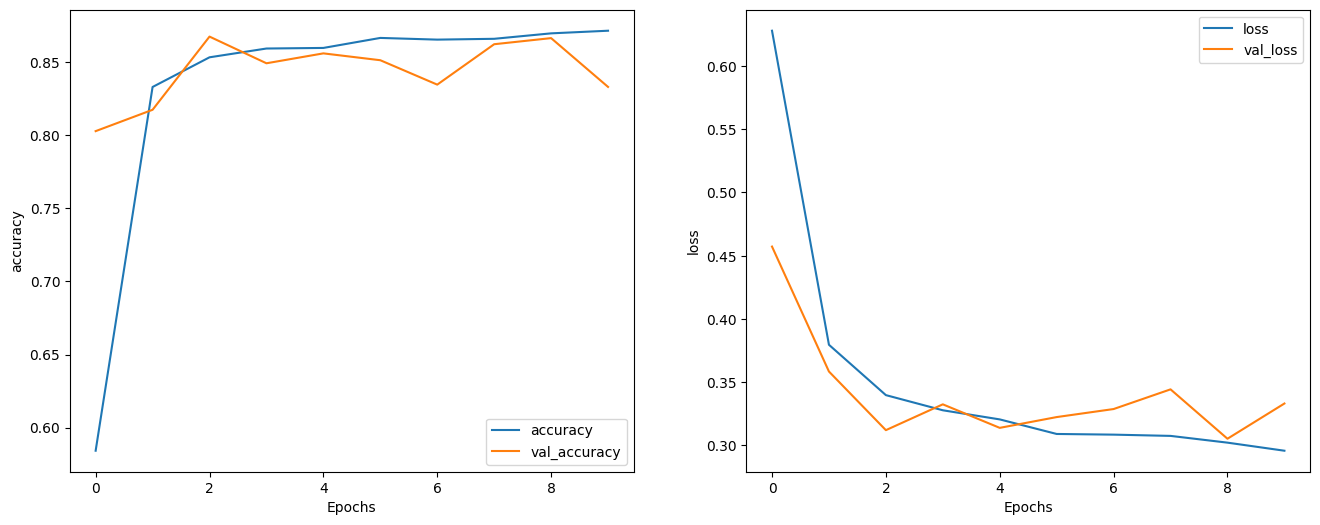

In [33]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#**PRAKTIKUM 2**


---

Generator Teks dengan RNN


**Setup**

Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file(
    'shakespeare.txt',  # This should be the filename you want to save it as
    origin='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'  # This is the URL of the file
)

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks


In [ ]:
example_texts=['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### **Buat Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      # Fix: Initialize the state with the correct shape using tf.zeros
      batch_size = tf.shape(x)[0]
      states = tf.zeros([batch_size, self.gru.units], dtype=tf.float32) # Initialize with zeros and correct shape

    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### **Uji Model**

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (64, 100, 256)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ((64, 100, 1024), (64,      │       3,938,304 │
│                                      │ 1024))                      │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (64, 100, 66)               │          67,650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,022,850 (15.35 MB)

 Trainable params: 4,022,850 (15.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([ 3,  8, 28, 24, 16, 55, 34, 21,  6,  7, 13, 18, 18, 44, 16, 10, 15,
       52,  4, 22, 31, 35,  9, 28, 12, 36,  8, 28, 19, 39, 46, 29, 58, 18,
       56, 65, 65, 12, 38, 41, 18,  4, 17, 45, 29, 50, 22, 65,  2, 54, 39,
       54, 60, 30, 18, 29, 43, 17, 49, 10,  1, 30,  1, 54, 32, 44, 50, 51,
        6, 14, 11, 38, 11, 64, 17,  3, 59, 16, 45, 35, 44, 45, 43, 50, 44,
        2, 65, 60, 55, 11, 59, 62, 61, 10, 27, 20,  8, 32,  6, 58])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'\nmany of us: that we did, we did for the best; and\nthough we willingly consented to his banishment, '

Next Char Predictions:
 b"!-OKCpUH',?EEeC3Bm$IRV.O;W-OFZgPsEqzz;YbE$DfPkIz oZouQEPdDj3\nQ\noSekl'A:Y:yD!tCfVefdke zup:twv3NG-S's"


**Train Model**

Tambahan optimizer dan fungsi loss


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1898894, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.01549

In [ ]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Cekpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Add .weights.h5 to the filename
checkpoint_prefix += ".weights.h5"  # This line is the fix

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training


In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
 13/172 ━━━━━━━━━━━━━━━━━━━━ 15:56 6s/step - loss: 4.3398

KeyboardInterrupt: 

### **Generate Teks**

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model  # Changed model8 to model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

**Ekspor Model Generator**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

# **TUGAS**

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_state()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))